### 导入必须的数学包和图形库并配置

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab

### 获得未加噪声的数据（x, y），正弦函数，周期为2$\pi$，取样步长为0.1$\pi$，取一个周期

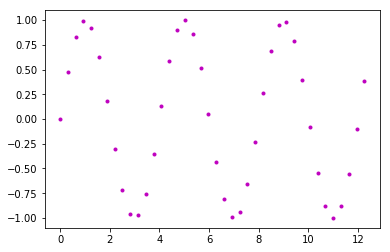

In [8]:
T = 2 * math.pi
n = 2
step = (T / n) * 0.1

x_raw = np.arange(0, 2*T, step, float)
y_raw = np.sin(math.pi / 2 * x_raw)

plt.plot(x_raw, y_raw, color='m', linestyle='', marker='.')
plt.show()

### 为数据加上高斯白噪声，均值0，方差0.2

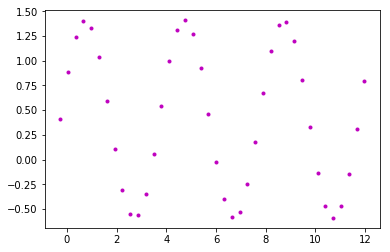

In [9]:
mu = 0
sigma = 0.2

x = x_raw + random.gauss(mu, sigma)
y = y_raw + random.gauss(mu, sigma)

x = np.transpose(np.mat(x))
y = np.transpose(np.mat(y))

plt.plot(x, y, color='m', linestyle='', marker='.')
plt.show()

### 根据最小二乘法使用1-16阶的多项式拟合数据

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yyzo0dxrj309902kmx7.jpg)

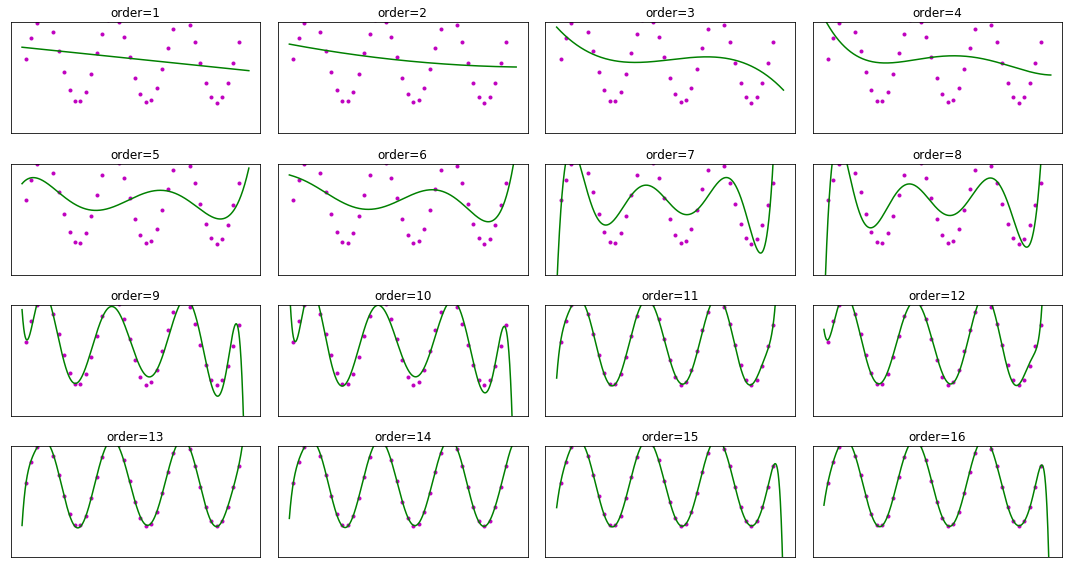

In [10]:
def least_square(x, y, order):
    matrix_left = np.empty([order + 1, order + 1], dtype = float)
    matrix_right = np.empty([order + 1, 1], dtype = float)
    for i in range(0, order + 1):
        row = matrix_left[i]
        for j in range(i, order + 1 + i):
            sum = 0
            for xx in x:
                sum = sum + xx**j
            row[j - i] = sum
    
    for i in range(0, order + 1):
        sum = 0
        j = 0
        for xx in x:
            sum = sum + y[j] * xx**i
            j = j + 1
        matrix_right[i][0] = sum
    
    return np.linalg.solve(matrix_left, matrix_right)

def func_solve(x, a):
    y=0
    for i in range(len(a)):
        y+=a[i]*x**i
    return y

pylab.rcParams['figure.figsize'] = (15.0, 8.0)
for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    ax.set_title('order=' + str(i+1))
    plt.xticks(())
    plt.yticks(())
    a = least_square(x, y, i+1)
    after_x = np.arange(-0.5, 2*T, 0.01)
    after_y = func_solve(after_x, a)
    plt.ylim([-1.3, 1.25])
    plt.plot(x, y, color='m', linestyle='', marker='.')
    plt.plot(after_x,after_y,color='g',linestyle='-',marker='')

plt.tight_layout()
plt.show()

### 120阶可观察过拟合情况

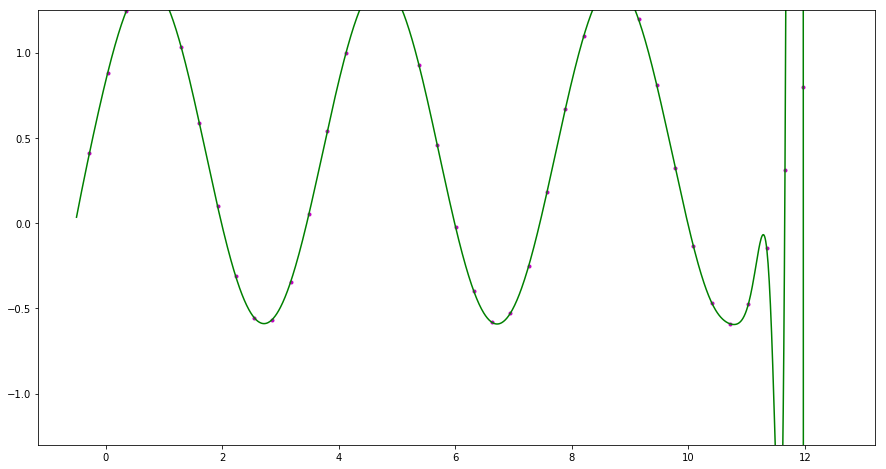

In [11]:
a = least_square(x, y, 120)
after_x = np.arange(-0.5, 2*T, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 最小二乘法的解析解（无正则项）
![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yy5zwc4aj304v02i0sm.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6ywn8f1vlj3060027weg.jpg)

In [19]:
# 注意此处的x与y是样本的x和y
def analytical_solution_without_regularizer(x, y, order):
    
    matrix_left = np.ones((len(x), order+1), dtype = float)
    
    for i in range(len(x)):
        for j in range(order+1):
            matrix_left[i][j] = x[i]**j
            
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_left), matrix_left)), np.transpose(matrix_left)),  y)

### 使用解析解拟合10阶多项式

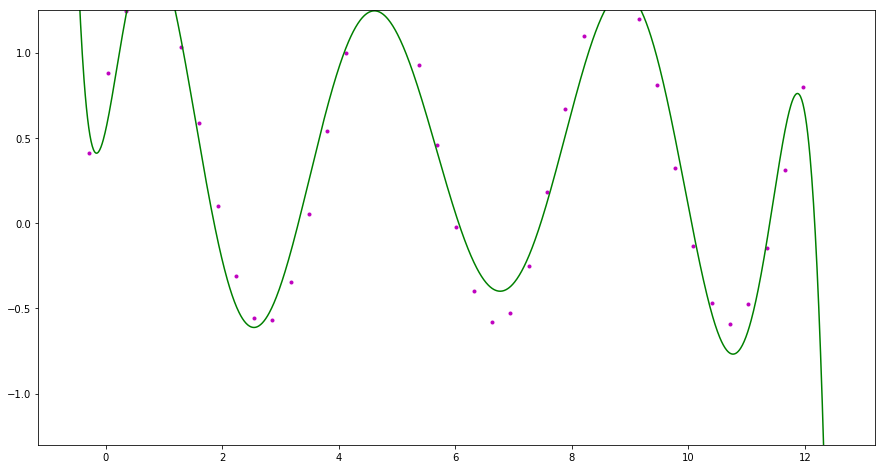

In [20]:
a = analytical_solution_without_regularizer(x, y, 10)

after_x = np.arange(-0.5, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, a))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x, after_y, color='g',linestyle='-',marker='')
plt.show()

### 使用有正则项的解析解（过度惩罚可能导致退化）

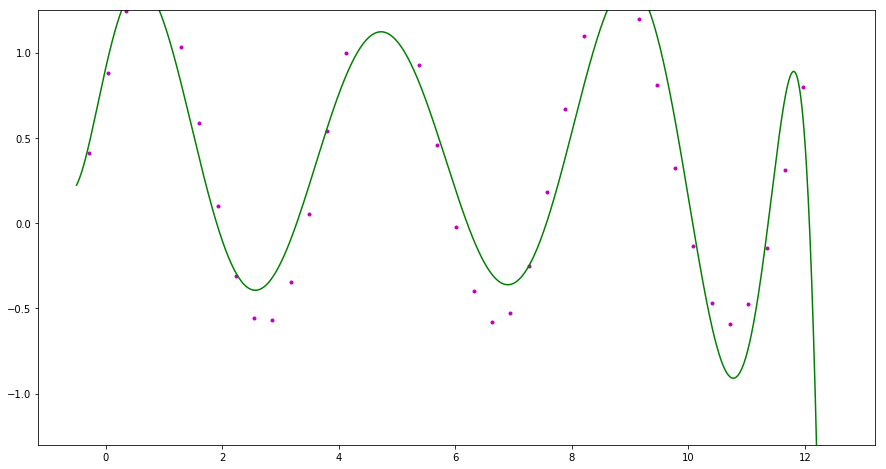

In [23]:
def analytical_solution_with_regularizer(x, y, order, regularizer):
    
    matrix_left = np.ones((len(x), order+1), dtype = float)
    
    for i in range(len(x)):
        for j in range(order+1):
            matrix_left[i][j] = x[i]**j
    
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_left), matrix_left) +  regularizer * np.eye(order+1)), np.transpose(matrix_left)),  y)

a = analytical_solution_with_regularizer(x, y, 10, 0.1)

after_x = np.arange(-0.5, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, a))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 使用梯度下降法拟合函数

定义代价函数（均方误差代价函数）及其梯度为：

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6z9rt8m3sj30cj02v0ss.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6za6xpl3kj30ec05zjro.jpg)

In [24]:
# number of example points
m = len(x)

def loss_function(theta, X, y):
    temp = np.dot(X, theta) - np.transpose(y)
    return (1.0 / (2 * m)) * np.dot(np.transpose(temp), temp)

def gradient_function(theta, X, y):
    temp = np.dot(X, theta) - y
    return (1.0 / m) * np.dot(np.transpose(X), temp)

梯度下降法

In [25]:
def gradient_decent(theta, alpha, X, y):
    # theta为初始位置（列向量）
    gradient = gradient_function(theta, X, y)
    while not np.all(np.absolute(gradient) <= 1e-5):
        theta = theta - alpha * gradient
        gradient = gradient_function(theta, X, y)
    return theta

使用梯度下降法拟合一阶多项式

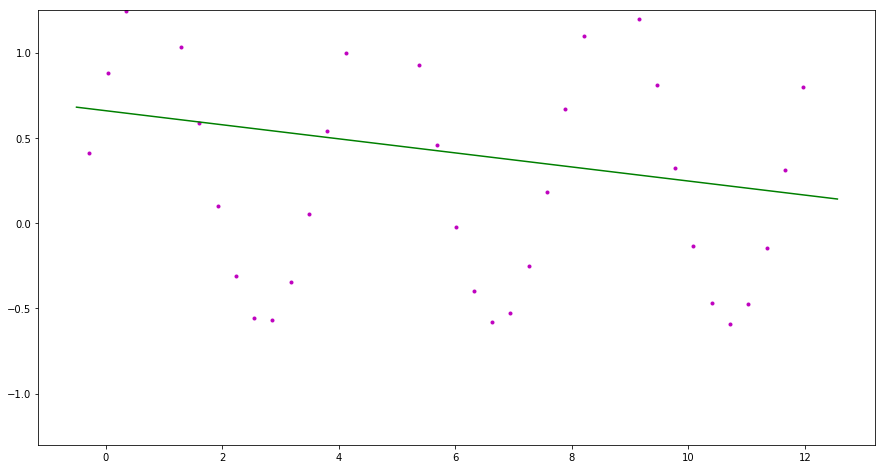

In [32]:
order = 1

theta = np.ones((order + 1, 1))
alpha = 0.01

X = np.zeros((m, order + 1))
for i in range(m):
    for j in range(order + 1):
        if j == 0:
            X[i][j] = 1
        else:
            X[i][j] = X[i][j-1] * x[i]
            
res = gradient_decent(theta, alpha, X, y)

after_x = np.arange(-0.5, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, res))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.25])
plt.plot(np.transpose(x), np.transpose(y), color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()